In [79]:
# This notebook contains code to replicate Figure 3 "Representative recording traces from NOs measured using three shell MEAs."

# This includes long term recording plots and analysis
# The notebook loads raw data and spike times from same organoid over different days
# This notebook analyzes spontaneous, not stimulated, activity 

# To reproduce, run each cell in order


In [80]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss

from probeinterface import Probe, ProbeGroup
from probeinterface import generate_linear_probe, generate_multi_shank
from probeinterface import combine_probes
from probeinterface.plotting import plot_probe

import datetime
from uuid import uuid4

import numpy as np
from dateutil.tz import tzlocal

from pynwb import NWBHDF5IO, NWBFile
from pynwb.ecephys import LFP, ElectricalSeries
from pprint import pprint
import matplotlib

#SCALING CONSTANTS
INTAN_RAW_DATA_SCALING_FACTOR = (1/1000) #units/microvolt - Intan data is in uVs, NWB is scaled down by 1000 
INTAN_SPIKE_TEMPLATE_SCALING_FACTOR = 1000000 #units/microvolt - NWB data scaled by 10^6 in spike interface pipeline
INTAN_FS = 30000 #samples/second

In [81]:
# Helper functions for plotting 

def getmin(arr):
    overallmin = 0
    for i in np.arange(arr.shape[0]):
        for j in np.arange(arr.shape[1]):
            electrode_min = np.min(np.abs(arr[i][j]))
            if(i == 0 and j == 0):
                overallmin = electrode_min
            if(electrode_min < overallmin):
                overallmin = electrode_min
    return overallmin

def getmax(arr):
    overallmax = 0
    for i in np.arange(arr.shape[0]):
        for j in np.arange(arr.shape[1]):
            electrode_max = np.max(np.abs(arr[i][j]))
            if(i == 0 and j == 0):
                overallmax = electrode_max
            if(electrode_max > overallmax):
                overallmax = electrode_max
    return overallmax

def gen_probe():
    north = generate_linear_probe(num_elec=1)
    north.rotate(180)
    north.set_contacts(positions=[[0,75]])


    east = generate_linear_probe(num_elec=1)
    east.rotate(90)
    east.set_contacts(positions=[[75,0]])

    west = generate_linear_probe(num_elec=1)
    west.rotate(-90)
    west.set_contacts(positions=[[-75,0]])

    multi_shank = combine_probes([west, east, north])
    multi_shank.set_device_channel_indices([0,1,2])
    return multi_shank

# Analysis of SO1 - ExperimentalData_2MonthRound1

In [92]:
fpath = '/PATH_TO_DATA/figure3/'

## Recreating Figure 3A
plot channels from the same organoid on different days

In [89]:
recordings = ['SO1_230613_PreStim.nwb', 'SO1_230615_PreStim.nwb', 'SO1_230620_PreStim.nwb',
              'SO1_230622_PreStim.nwb', 'SO1_230629_PreStim.nwb', 'SO1_230705_PreStim.nwb',
              'SO1_230706_PreStim.nwb', 'SO1_230718_WestPreStim.nwb', 'SO1_230721_PreStim.nwb']

In [90]:
threshs = [15, 10, 10, 10, 7.5, 10, 8, 6, 6]

In [94]:
recs_prep = []

for i in np.arange(len(recordings)):
    thresh = threshs[i]
    recording = recordings[i]

    rec = se.read_nwb_recording(fpath+recording)#,electrical_series_name="ES")
    multi_shank = gen_probe()
    rec = rec.set_probe(multi_shank)

    rec_filt = spre.bandpass_filter(rec, freq_min=300, freq_max=6000)
    #remove whitening here- use absolute value for plotting
    #rec: si.BaseRecording = spre.whiten(rec_filt, dtype='float32')
    
    #Skip artifact removal for plotting
    #chan = rec.get_traces()[:,0]
    #stim_trig_fr = np.where(np.abs(chan) > thresh)
    #recording_rmartifact = spre.remove_artifacts(rec,
    #                                            list_triggers=stim_trig_fr[0].tolist(),
    #                                            ms_before=10, ms_after=10)
    
    #if(i == 2):
    #    chan = rec.get_traces()[:,1] 
    #    stim_trig_fr = np.where(np.abs(chan) > thresh)
    #    recording_rmartifact = spre.remove_artifacts(rec,
    #                                                list_triggers=stim_trig_fr[0].tolist(),
    #                                                ms_before=10, ms_after=10)
    
    recs_prep.append(rec_filt)

    

In [95]:
# start day: 06/08/2023; note: start day = 1st day of recording
# when was day of differentiation?
days = ['Day 5', 'Day 7', 'Day 12', 'Day 19', 'Day 26', 'Day 32', 'Day 33', 'Day 45', 'Day 48']
short_days = [days[0],days[4],days[5],days[6]]
short_recordings = [recordings[0],recordings[4],recordings[5],recordings[6]]
day_nums = [5, 7, 12, 19, 26, 32, 33, 45, 48]
short_index = [0,4,5,6]
fs = 30000
winlen = 25 #plot 2 seconds of data
startsample = 275*fs #start plot 60 seconds into recording

In [96]:
#fig, ax = plt.subplots(1, len(recordings), sharex=True, sharey=True)

alldata = []
for i in np.arange(len(short_recordings)):
    #WEN
    west = recs_prep[short_index[i]].get_traces()[startsample:startsample+winlen*fs,0]
    east = recs_prep[short_index[i]].get_traces()[startsample:startsample+winlen*fs,1]
    north = recs_prep[short_index[i]].get_traces()[startsample:startsample+winlen*fs,2]

    alldata.append([np.array(west), np.array(east), np.array(north)])

alldata = np.array(alldata)

cmap = matplotlib.cm.get_cmap('Spectral')


/var/folders/hm/84vk_wz50y3bvl1dt4xw9fyh0000gp/T/ipykernel_58633/1888681759.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


In [97]:

dy = (getmin(alldata) - getmax(alldata)) * 1.5 
dy

np.float64(-0.3837897109106923)

In [108]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import transforms
def add_time_scalebar(ax, length_x, label=None, loc='lower right', 
                      margin_pts=6, lw=5, color='k'):
    # Get data limits
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    dx = x1 - x0
    dy = y1 - y0

    # Anchor position in data coords
    # corners in data coords with a small data-space vertical offset
    if loc in ('lower right', 'lr'):
        x_end = x1 - 0.02*dx
        y = y0 - 0.001*dy#+ dy
        ha = 'right'
    elif loc in ('lower left', 'll'):
        x_end = x0 + 0.02*dx
        y = y0 + 0.05*dy
        ha = 'left'
    elif loc in ('upper right', 'ur'):
        x_end = x1 - 0.02*dx
        y = y1 - 0.05*dy
        ha = 'right'
    else:  # 'upper left'
        x_end = x0 + 0.02*dx
        y = y1 - 0.05*dy
        ha = 'left'

    # Draw the horizontal bar in DATA units
    line = Line2D([x_end - length_x, x_end], [y, y], color=color, lw=lw)
    ax.add_line(line)

    # Optional label, nudged by a few points
    if label:
        offset = transforms.ScaledTranslation(0, 3/72, ax.figure.dpi_scale_trans)
        ax.text(x_end - length_x/2, y, label,
                transform=ax.transData + offset,
                ha='center', va='bottom', color=color)

def add_amp_scalebar(ax, height_y, label=None, loc='lower right', 
                     margin_pts=6, lw=2, color='k'):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    dx = x1 - x0
    dy = y1 - y0

    if loc in ('lower right', 'lr'):
        x = x1 - 0.01*dx
        y_base = y0 #- 0.005*dy
        #y_base = y0 +0.05*dy#+ 0.05*dy
        va = 'bottom'
    elif loc in ('lower left', 'll'):
        x = x0 + 0.02*dx
        y_base = y0 + 0.05*dy
        va = 'bottom'
    elif loc in ('upper right', 'ur'):
        x = x1 - 0.02*dx
        y_base = y1 - 0.05*dy - height_y
        va = 'bottom'
    else:  # 'upper left'
        x = x0 + 0.02*dx
        y_base = y1 - 0.05*dy - height_y
        va = 'bottom'

    line = Line2D([x, x], [y_base, y_base - height_y], color=color, lw=lw)
    ax.add_line(line)

    if label:
        offset = transforms.ScaledTranslation(0, 3/72, ax.figure.dpi_scale_trans)
        ax.text(x, y_base + height_y, label,
                transform=ax.transData + offset,
                ha='center', va=va, color=color)

750000
750000
750000
750000


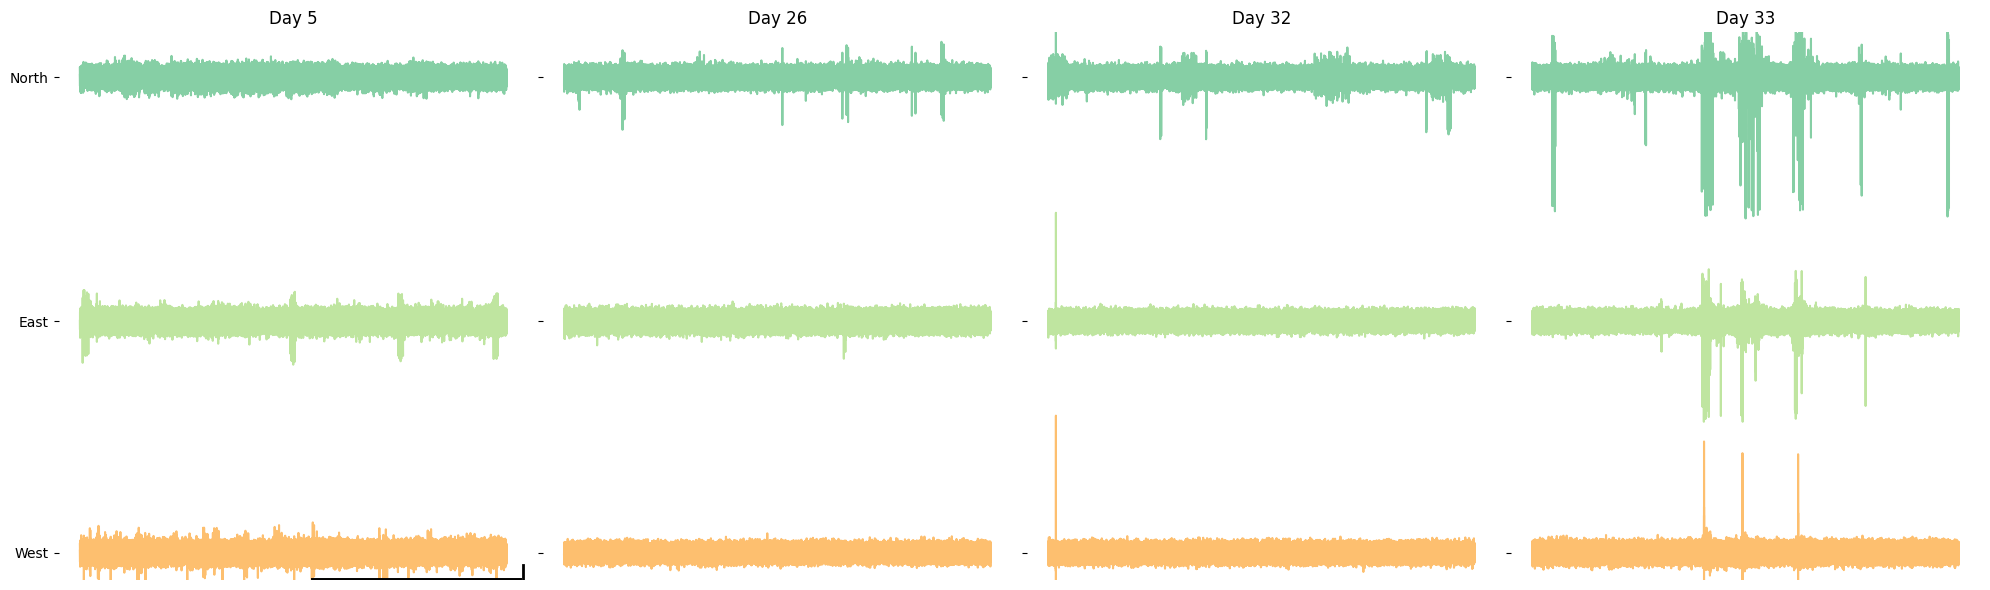

In [109]:
#UPDATED PLOTTNG EXAMPLE
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
rgba1 = cmap(1/3)
rgba2 = cmap(2/3)
rgba3 = cmap(3/4)

fig, ax = plt.subplots(1, len(short_recordings), sharex=True, sharey=True, figsize=(20,6), layout='tight')

for i in np.arange(len(ax)):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    print(len(alldata[i][0]))

    ax[i].plot(alldata[i][0] + dy-0.088, color=rgba1)
    ax[i].plot(alldata[i][1] + (1.5*dy)-0.05, color=rgba2)
    ax[i].plot(alldata[i][2] + (2*dy)-0.02, color=rgba3)

    ax[i].get_xaxis().set_visible(False)
    ax[i].set_title(days[short_index[i]])

plt.ylim(dy-0.07, (2*dy-0.05))

#plt.tight_layout()
plt.yticks([dy-0.088, (dy*1.5)-0.05, (2*dy)-0.02], labels=['West', 'East', 'North'])

length_x = INTAN_FS*12
# time bar of 12 s on the first panel
add_time_scalebar(ax[0], length_x=length_x, label='', loc='lower right', color='black')

# amplitude bar of 10 µV (convert to your y-data via INTAN_RAW_DATA_SCALING_FACTOR)
add_amp_scalebar(ax[0], height_y=10*INTAN_RAW_DATA_SCALING_FACTOR, 
                 label='', loc='lower right', color='black')

# Save the plot as an SVG file
plt.savefig('fig3A.svg') 

## Figure 3E - PSDs

/var/folders/hm/84vk_wz50y3bvl1dt4xw9fyh0000gp/T/ipykernel_58633/1939866223.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


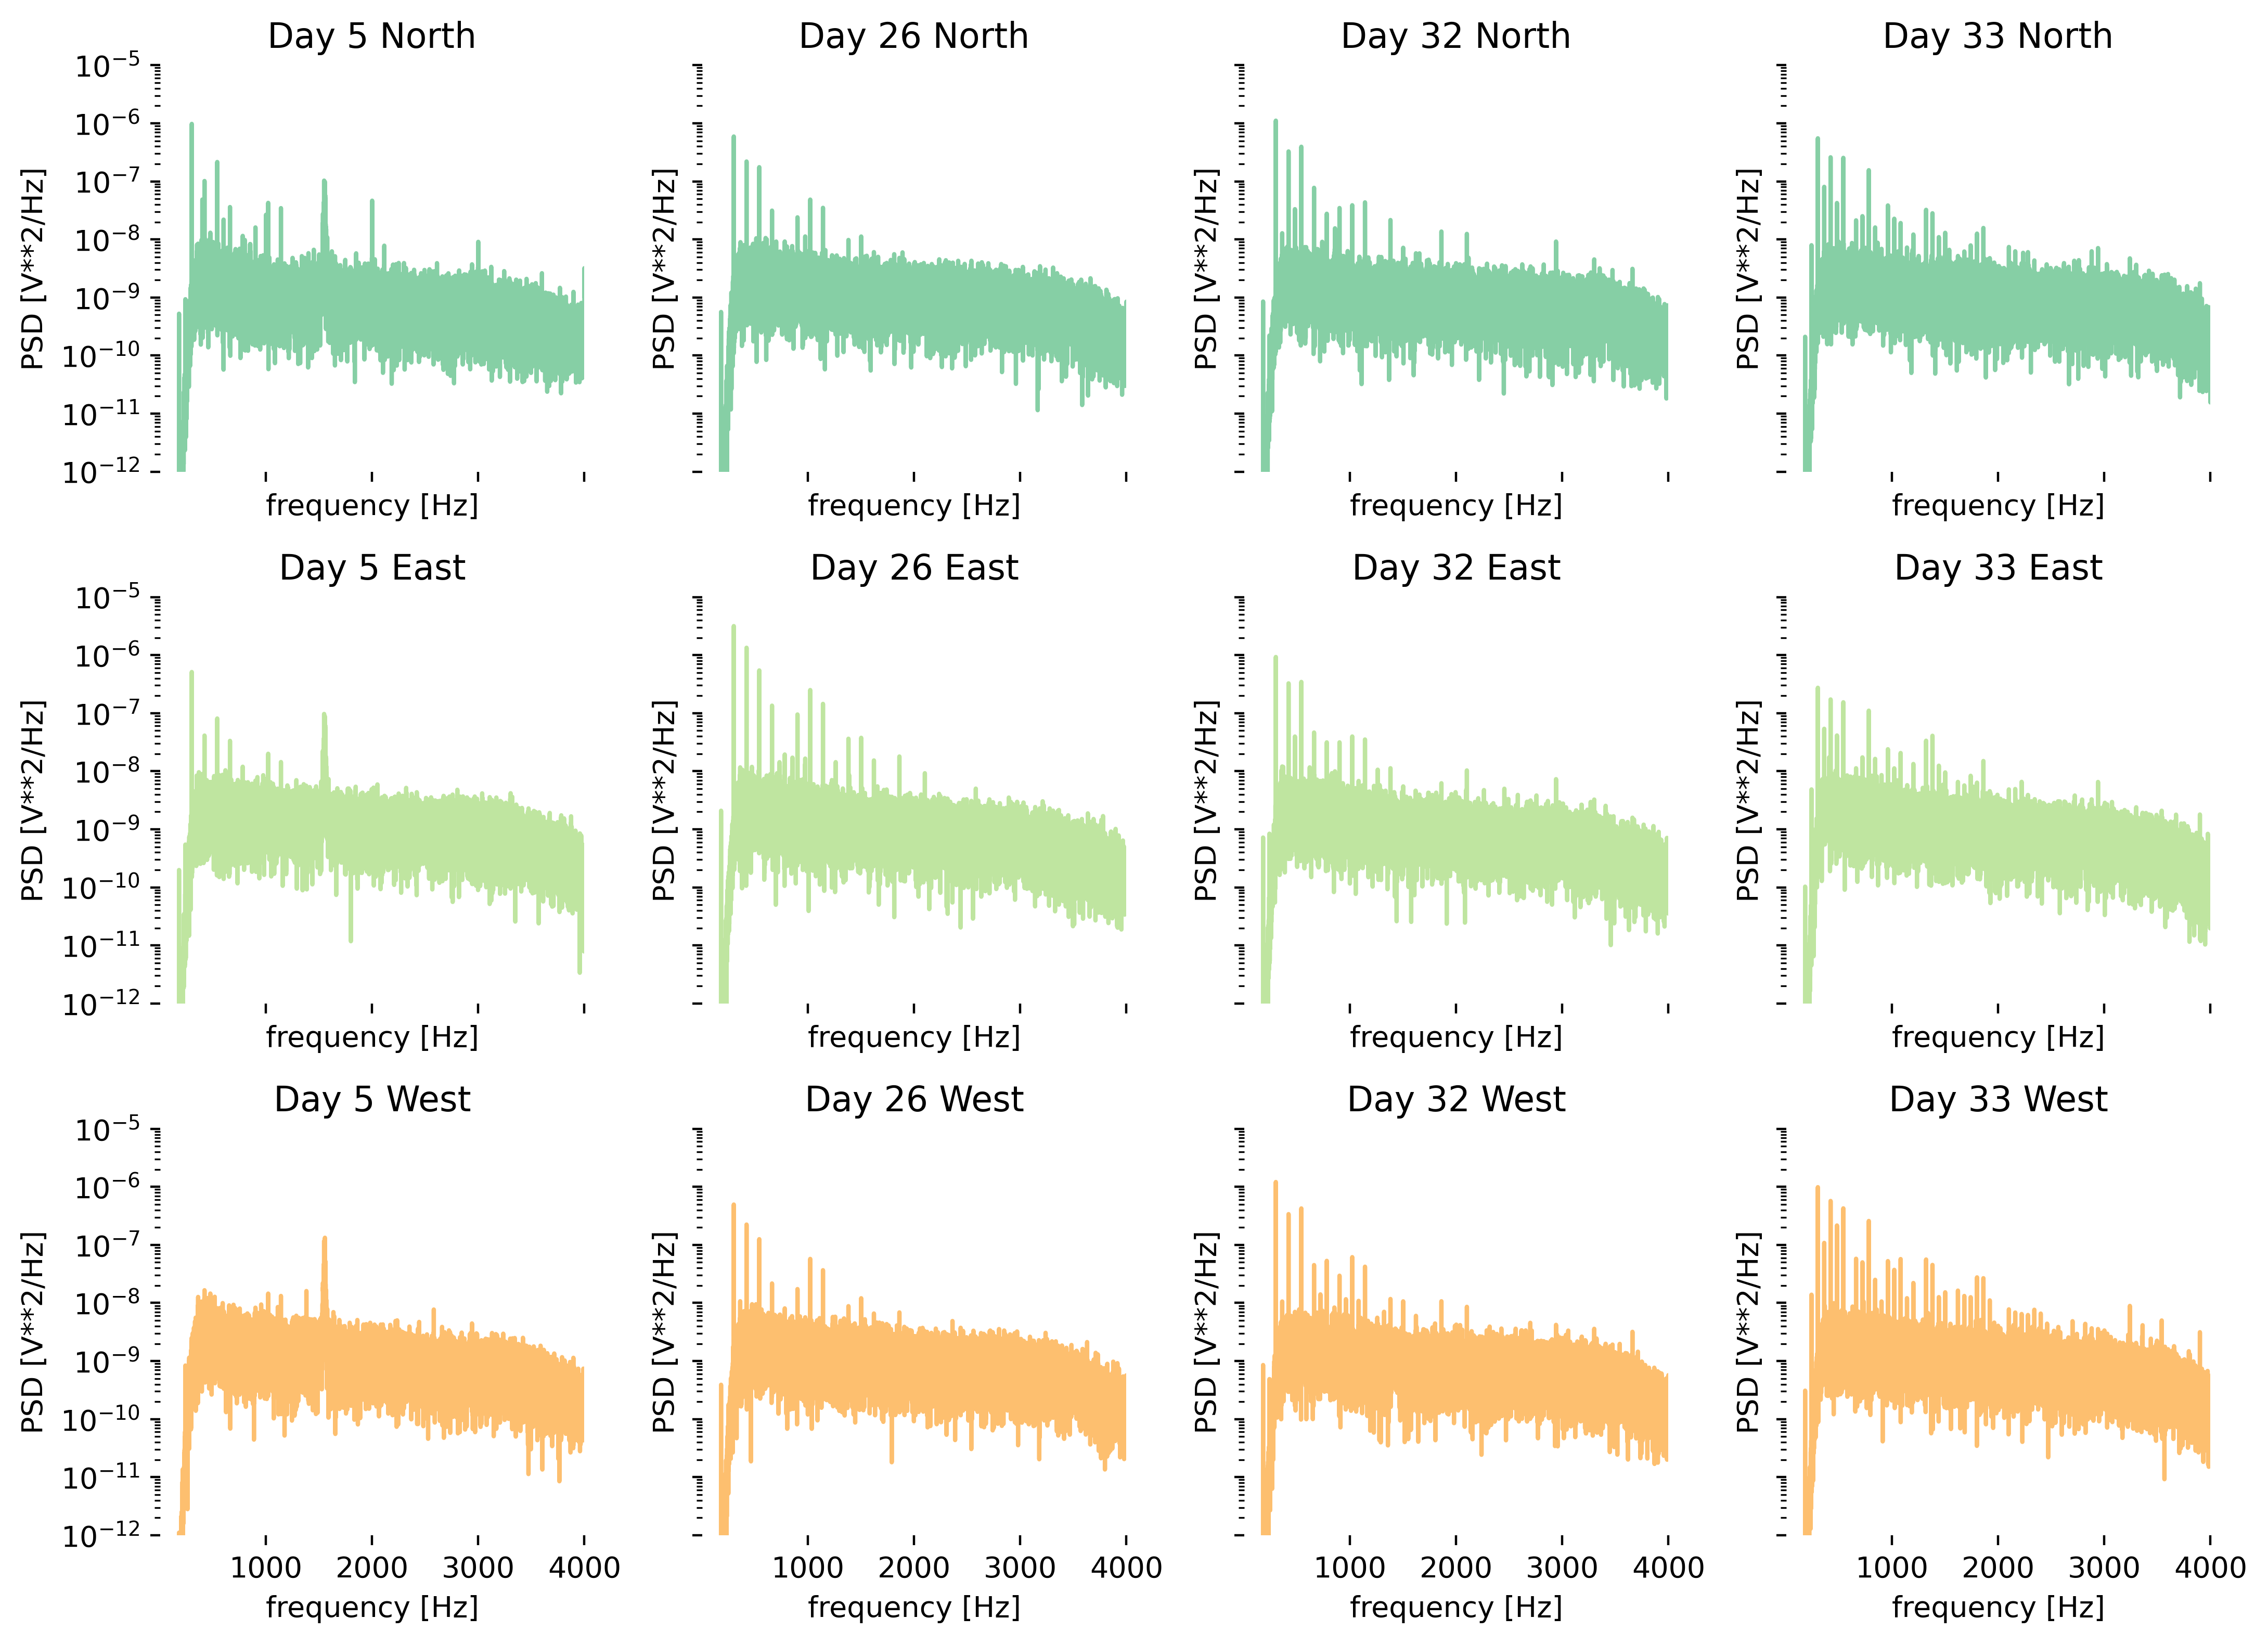

In [19]:
# Plot PSD over days
# start day: 06/08/2023; note: start day = 1st day of recording
# will use longer window for freq plotting to improve resolution 
fs = 30000
winlen = 10 #plot 10 seconds of data
startsample = 60*fs #start plot 60 seconds into recording
electrodes = ['North','East','West']
alldata = []
for i in np.arange(len(short_recordings)):
    #WEN
    recording_lfp = spre.bandpass_filter(recs_prep[short_index[i]], freq_min=1, freq_max=4000)
    west = recording_lfp.get_traces()[startsample:startsample+winlen*fs,0]
    east = recording_lfp.get_traces()[startsample:startsample+winlen*fs,1]
    north = recording_lfp.get_traces()[startsample:startsample+winlen*fs,2]

    #change order for easier plotting
    alldata.append([np.array(north), np.array(east), np.array(west)])

alldata = np.array(alldata)

cmap = matplotlib.cm.get_cmap('Spectral')

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
rgba1 = cmap(1/3)
rgba2 = cmap(2/3)
rgba3 = cmap(3/4)
rgb_vect = [rgba1,rgba2, rgba3]

fig, ax = plt.subplots(3, len(short_recordings), sharex=True, sharey=True, layout='tight', dpi=400, figsize=(11,8))

#Plot PSD of lfp signal
from scipy import signal

for i in np.arange(len(short_recordings)):
    for j in np.arange(3):
        f, Pxx_den = signal.welch(alldata[i][j], fs, nperseg=fs*5)
        ax[j][i].spines['right'].set_visible(False)
        ax[j][i].spines['left'].set_visible(False)
        ax[j][i].spines['bottom'].set_visible(False)
        ax[j][i].spines['top'].set_visible(False)

        ax[j][i].semilogy(f, Pxx_den, color=rgb_vect[len(rgb_vect)-1-j])
        ax[j][i].set_title(days[short_index[i]]+' '+electrodes[j])
        ax[j][i].set_xlabel('frequency [Hz]')
        ax[j][i].set_xlim(1,4000)
        ax[j][i].set_ylim(10**(-12),10**(-5))
        ax[j][i].set_ylabel('PSD [V**2/Hz]')


## Recreating Fig 3B

In [110]:
cmap = matplotlib.cm.get_cmap('Spectral')

/var/folders/hm/84vk_wz50y3bvl1dt4xw9fyh0000gp/T/ipykernel_58633/656610029.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


In [111]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import transforms
def spike_add_time_scalebar(ax, length_x, label=None, loc='lower right', 
                      margin_pts=6, lw=5, color='k'):
    # Get data limits
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    dx = x1 - x0
    dy = y1 - y0

    # Anchor position in data coords
    # corners in data coords with a small data-space vertical offset
    if loc in ('lower right', 'lr'):
        x_end = x1 - 0.02*dx
        y = y0 - 0.001*dy#+ dy
        ha = 'right'
    elif loc in ('lower left', 'll'):
        x_end = x0 + 0.02*dx
        y = y0 + 0.05*dy
        ha = 'left'
    elif loc in ('upper right', 'ur'):
        x_end = x1 - 0.02*dx
        y = y1 - 0.05*dy
        ha = 'right'
    else:  # 'upper left'
        x_end = x0 + 0.02*dx
        y = y1 - 0.05*dy
        ha = 'left'

    # Draw the horizontal bar in DATA units
    line = Line2D([x_end - length_x, x_end], [y, y], color=color, lw=lw)
    ax.add_line(line)

    # Optional label, nudged by a few points
    if label:
        offset = transforms.ScaledTranslation(0, 3/72, ax.figure.dpi_scale_trans)
        ax.text(x_end - length_x/2, y, label,
                transform=ax.transData + offset,
                ha='center', va='bottom', color=color)

def spike_add_amp_scalebar(ax, height_y, label=None, loc='lower right', 
                     margin_pts=6, lw=2, color='k'):
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    dx = x1 - x0
    dy = y1 - y0

    if loc in ('lower right', 'lr'):
        x = x1 - 0.01*dx
        y_base = y0 + 0.1*dy
        #y_base = y0 +0.05*dy#+ 0.05*dy
        va = 'bottom'
    elif loc in ('lower left', 'll'):
        x = x0 + 0.02*dx
        y_base = y0 + 0.05*dy
        va = 'bottom'
    elif loc in ('upper right', 'ur'):
        x = x1 - 0.02*dx
        y_base = y1 - 0.05*dy - height_y
        va = 'bottom'
    else:  # 'upper left'
        x = x0 + 0.02*dx
        y_base = y1 - 0.05*dy - height_y
        va = 'bottom'

    line = Line2D([x, x], [y_base, y_base - height_y], color=color, lw=lw)
    ax.add_line(line)

    if label:
        offset = transforms.ScaledTranslation(0, 3/72, ax.figure.dpi_scale_trans)
        ax.text(x, y_base + height_y, label,
                transform=ax.transData + offset,
                ha='center', va=va, color=color)

(5, 90, 3)
(3, 90, 3)
(2, 90, 3)
(4, 90, 3)
24400524.0


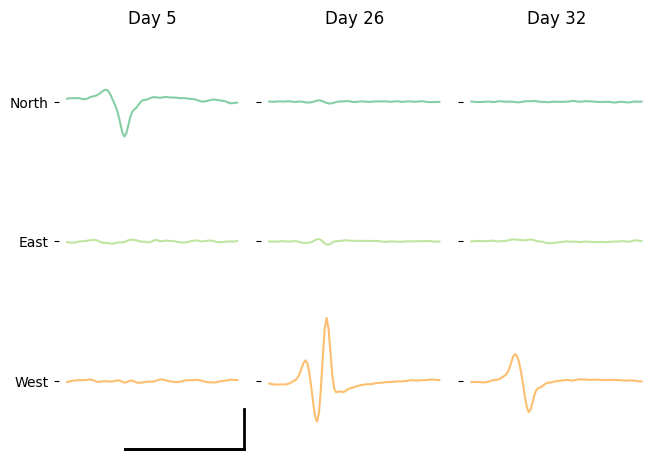

In [113]:
# Plot spike templates
#fig, ax = plt.subplots(1, len(recordings), sharex=True, sharey=True)

alldata = []
spike_template_files = ['spikingdata_updated/SO1_230613waveforms_folder/templates_average.npy', 
                        'spikingdata_updated/SO1_230615waveforms_folder/templates_average.npy', 
                        'spikingdata_updated/SO1_230620waveforms_folder/templates_average.npy',
                        'spikingdata_updated/SO1_230622waveforms_folder/templates_average.npy', 
                        'spikingdata_updated/SO1_230629waveforms_folder/templates_average.npy', 
                        'spikingdata_updated/SO1_230705waveforms_folder/templates_average.npy',
                        'spikingdata_updated/SO1_230706waveforms_folder/templates_average.npy',
                        #'', 
                        'spikingdata_updated/SO1_230721waveforms_folder/templates_average.npy']
fpath_spikes = '/PATH_TO_DATA/figure3/'

#Match plot in figure
short_days = [days[0],days[4],days[5],days[6]]
short_recordings = [recordings[0],recordings[4],recordings[5],days[6]]
short_index = [0,4,5,6]

short_spike_inds = [1,1,1,0]
alldata = []
dy = 0
for i in np.arange(len(short_recordings)):
    template_data = np.load(fpath_spikes+spike_template_files[short_index[i]])
    print(template_data.shape)
    alldata.append(template_data[short_spike_inds[i]])
    dy = max([dy,(getmin(template_data[short_spike_inds[i]]) - getmax(template_data[short_spike_inds[i]])) * -1])

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
rgba1 = cmap(1/3)
rgba2 = cmap(2/3)
rgba3 = cmap(3/4)

print(dy)
#plt.plot(alldata[0][:,2])
fig, ax = plt.subplots(1, len(short_recordings)-1, sharex=True, sharey=True)
for i in np.arange(len(ax)):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    ax[i].plot(alldata[i][:,2] + 0.5*dy, color=rgba1)
    ax[i].plot(alldata[i][:,1] + 1.5*dy, color=rgba2)
    ax[i].plot(alldata[i][:,0] + 2.5*dy, color=rgba3)

    ax[i].get_xaxis().set_visible(False)
    ax[i].set_title(days[short_index[i]])

plt.ylim(0, (3*dy))
plt.tight_layout()
plt.yticks([0.5*dy, dy*1.5, 2.5*dy], labels=['West', 'East', 'North'])

length_x = INTAN_FS*0.002
# time bar of 2 ms on the first panel
spike_add_time_scalebar(ax[0], length_x=length_x, label='', loc='lower right', color='black')

# amplitude bar of 10 µV (convert to your y-data via INTAN_RAW_DATA_SCALING_FACTOR)
spike_add_amp_scalebar(ax[0], height_y=10*INTAN_SPIKE_TEMPLATE_SCALING_FACTOR, 
                 label='', loc='lower right', color='black')



(5, 90, 3)
(4, 90, 3)
(2, 90, 3)
7171473.5


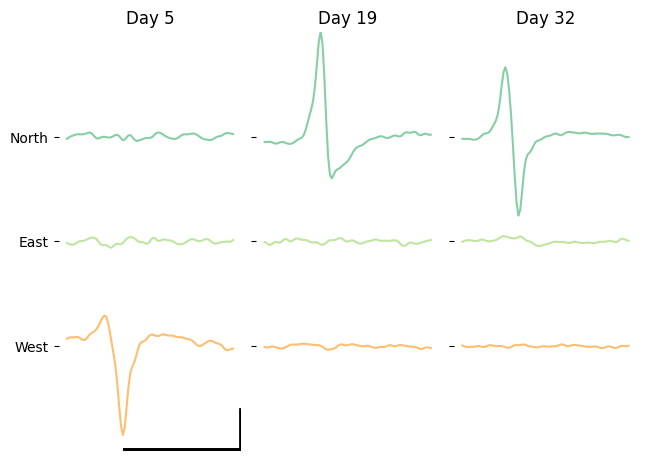

In [115]:
#UPDATED PLOTTNG EXAMPLE
# Updated Plot - update days, add scale bars, make ordering consistent with 3A
short_days = [days[0],days[3],days[5]]
short_recordings = [recordings[0],recordings[3],recordings[5]]
short_index = [0,3,5,6]
# Plot spike templates
#fig, ax = plt.subplots(1, len(recordings), sharex=True, sharey=True)

alldata = []
spike_template_files = ['spikingdata_updated/SO1_230613waveforms_folder/templates_average.npy', 
                        'spikingdata_updated/SO1_230615waveforms_folder/templates_average.npy', 
                        'spikingdata_updated/SO1_230620waveforms_folder/templates_average.npy',
                        'spikingdata_updated/SO1_230622waveforms_folder/templates_average.npy', 
                        'spikingdata_updated/SO1_230629waveforms_folder/templates_average.npy', 
                        'spikingdata_updated/SO1_230705waveforms_folder/templates_average.npy',
                        'spikingdata_updated/SO1_230706waveforms_folder/templates_average.npy',
                        #'', 
                        'spikingdata_updated/SO1_230721waveforms_folder/templates_average.npy']
fpath_spikes = '/PATH_TO_DATA/figure3/'

#Match plot in figure

short_spike_inds = [1,1,1,0]
alldata = []
dy = 0
for i in np.arange(len(short_recordings)):
    template_data = np.load(fpath_spikes+spike_template_files[short_index[i]])
    print(template_data.shape)
    alldata.append(template_data[short_spike_inds[i]])
    dy = max([dy,(getmin(template_data[short_spike_inds[i]]) - getmax(template_data[short_spike_inds[i]])) * -1])

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
rgba1 = cmap(1/3)
rgba2 = cmap(2/3)
rgba3 = cmap(3/4)

print(dy)
#plt.plot(alldata[0][:,2])
fig, ax = plt.subplots(1, len(short_recordings), sharex=True, sharey=True)
for i in np.arange(len(ax)):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    ax[i].plot(alldata[i][:,0] + 1*dy, color=rgba1)
    ax[i].plot(alldata[i][:,1] + 2*dy, color=rgba2)
    ax[i].plot(alldata[i][:,2] + 3*dy, color=rgba3)

    ax[i].get_xaxis().set_visible(False)
    ax[i].set_title(days[short_index[i]])

plt.ylim(0, (4*dy))
plt.tight_layout()
plt.yticks([1*dy, dy*2, 3*dy], labels=['West', 'East', 'North'])

length_x = INTAN_FS*0.002
# time bar of 2 ms on the first panel
spike_add_time_scalebar(ax[0], length_x=length_x, label='', loc='lower right', color='black')

# amplitude bar of 5 µV (convert to your y-data via INTAN_RAW_DATA_SCALING_FACTOR)
spike_add_amp_scalebar(ax[0], height_y=5*INTAN_SPIKE_TEMPLATE_SCALING_FACTOR, 
                 label='', loc='lower right', color='black')

plt.savefig('fig3B.svg') 

In [11]:
import xarray as xr

In [15]:
# Plot spike templates
#fig, ax = plt.subplots(1, len(recordings), sharex=True, sharey=True)

alldata = []
spike_template_files = ['spikingdata_curated/SO1_230613waveforms_folder_curated/templates_average.npy', 
                        'spikingdata_curated/SO1_230615waveforms_folder_curated/templates_average.npy', 
                        'spikingdata_curated/SO1_230620waveforms_folder_curated/templates_average.npy',
                        'spikingdata_updated/SO1_230622waveforms_folder/templates_average.npy', 
                        'spikingdata_curated/SO1_230629waveforms_folder_curated/templates_average.npy', 
                        'spikingdata_updated/SO1_230705waveforms_folder/templates_average.npy',
                        'spikingdata_curated/SO1_230706waveforms_folder_curated/templates_average.npy',
                        #'', 
                        'spikingdata_updated/SO1_230721waveforms_folder/templates_average.npy']
fpath_spikes = '/PATH_TO_DATA/figure3/'

alldata = []
dy = 0
for i in np.arange(len(short_recordings)):
    template_data = np.load(fpath_spikes+spike_template_files[short_index[i]])
    print(template_data.shape)
    template = np.arange(1, template_data.shape[0]+1, 1)
    time = np.arange(0, template_data.shape[1]/fs, 1/fs)
    channel = ['North', 'East', 'West']

    da = xr.DataArray(template_data, coords=[template, time, channel], dims=['template', 'time', 'channel'])
    da['day'] = f'Day {day_nums[short_index[i]]:02d}'
    
    alldata.append(da)

    dy = max([dy,
              (getmin(template_data) - getmax(template_data)) * -1])
alldata
total_da = xr.concat(alldata, dim='day')
total_da

(3, 90, 3)
(1, 90, 3)
(2, 90, 3)
(2, 90, 3)


<xarray.DataArray (day: 4, template: 3, time: 90, channel: 3)> Size: 13kB
array([[[[-8.95742375e+05,  7.32724844e+04, -2.32931372e+03],
         [-9.18008500e+05,  8.95816406e+04, -8.11109668e+03],
         [-9.23272500e+05,  8.82649141e+04, -4.80778955e+03],
         ...,
         [ 4.58159969e+05, -4.58843086e+04, -8.91950625e+04],
         [ 4.69489750e+05, -9.08597969e+04, -1.05950703e+05],
         [ 4.55749719e+05, -9.67586797e+04, -9.20643359e+04]],

        [[-1.33926844e+05,  1.72051125e+05,  3.05862695e+04],
         [-9.96765547e+04,  8.91662891e+04,  5.62277051e+03],
         [-3.98686328e+04, -5.96117480e+03, -5.17306641e+04],
         ...,
         [ 6.65542109e+04, -1.61580000e+05, -5.47416641e+04],
         [ 2.43762129e+04, -1.33784516e+05,  3.12627715e+04],
         [-5.35822852e+04, -7.68636953e+04,  1.48194062e+05]],

        [[ 7.05066016e+03, -7.45494625e+05,  5.45552578e+04],
         [ 3.22393008e+04, -7.48493375e+05,  5.48138086e+04],
         [ 3.50655703e+04, -7.67084625e+05,  8.09488438e+04],
         ...,
...
         [ 6.66635703e+04,  8.09814531e+04,  4.93470562e+05],
         [ 4.13017578e+04,  6.57859375e+03,  4.97896719e+05],
         [ 6.08263672e+04, -7.43712109e+04,  5.22031125e+05]],

        [[ 1.22373445e+05,  6.36829375e+04, -1.97533550e+06],
         [ 1.35670891e+05,  4.97299102e+04, -2.07996212e+06],
         [ 1.76333562e+05,  9.79180391e+04, -2.13969525e+06],
         ...,
         [-5.45761250e+04, -1.18566742e+05,  9.86350750e+05],
         [-6.93804844e+04, -1.15923305e+05,  9.28129250e+05],
         [-6.51438711e+04, -7.45736719e+04,  8.78069250e+05]],

        [[            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan],
         [            nan,             nan,             nan],
         [            nan,             nan,             nan]]]],
      dtype=float32)
Coordinates:
  * template  (template) int64 24B 1 2 3
  * time      (time) float64 720B 0.0 3.333e-05 6.667e-05 ... 0.002933 0.002967
  * channel   (channel) <U5 60B 'North' 'East' 'West'
  * day       (day) <U6 96B 'Day 05' 'Day 26' 'Day 32' 'Day 33'

Day 05	Template 1	first
East
North
West
Day 05	Template 2
East
North
West
Day 05	Template 3
East
North
West
Day 26	Template 1
East
North
West
Day 32	Template 1
East
North
West
Day 32	Template 2
East
North
West
Day 33	Template 1
East
North
West
Day 33	Template 2
East
North
West


/tmp/ipykernel_1032266/1518374104.py:20: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for (day, day_da), gs in zip(template_da.transpose('day', 'template', 'channel', 'time').groupby('day', squeeze=True), gs_parent):
/tmp/ipykernel_1032266/1518374104.py:27: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for (temp, temp_da), i in zip(day_da.groupby('template', squeeze=True), np.arange(len(day_da.coords['template']))):
/tmp/ipykernel_1032266/1518374104.py:27: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for (temp, temp_da), i in zip(day_da.groupby('template', squeeze=True), np.arange(len(day_da.coords['templat

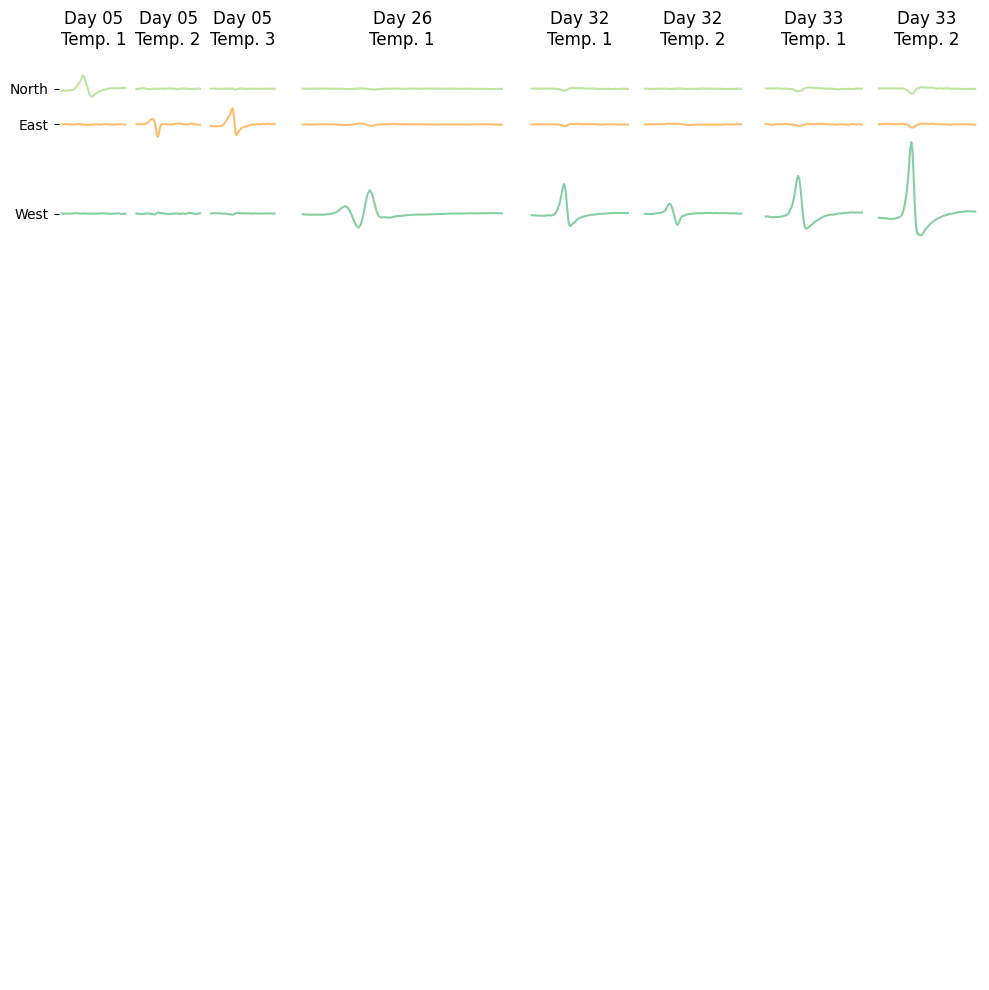

In [52]:
# Plot using nested gridspecs
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 10))

# ENW

#  W .  E .  N
# 0.5dy dy 2.5dy

# ENW
y_offsets = [0.994, 0.995, 0.9915]
rgbas = [rgba1, rgba2, rgba3]

# subplot for each day
# nested subplots for each template in each day
first_ax = None
template_da = total_da/(abs(total_da).max()*500)
gs_parent = gridspec.GridSpec(1, len(template_da.coords['day']), figure = fig)
for (day, day_da), gs in zip(template_da.transpose('day', 'template', 'channel', 'time').groupby('day', squeeze=True), gs_parent):
    n_temps = 0
    for temp, temp_da in day_da.groupby('template'):
        if(not np.any(np.isnan(temp_da))):
            n_temps += 1

    gs_day = gridspec.GridSpecFromSubplotSpec(1, n_temps, subplot_spec=gs)
    for (temp, temp_da), i in zip(day_da.groupby('template', squeeze=True), np.arange(len(day_da.coords['template']))):
        #temp_da = temp_da/temp_da.max()
        if(i < n_temps):
            if(first_ax == None):
                print(f'{day}\tTemplate {temp}\tfirst')
                ax = fig.add_subplot(gs_day[0, i])
                first_ax = ax
                ax.set_yticks([0.9915, 0.994, 0.995], labels=['West', 'East', 'North'])
            else:
                print(f'{day}\tTemplate {temp}')
                ax = fig.add_subplot(gs_day[0, i])
                #ax.set_yticks([])
                ax.sharey(first_ax)
                ax.axis('off')

            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['top'].set_visible(False)

            
            for (chan, chan_da), offset, rgba in zip(temp_da.groupby('channel', squeeze=True), y_offsets, rgbas):
                print(chan)
                ax.plot(chan_da[0] + offset, color=rgba)


            ax.get_xaxis().set_visible(False)
            ax.set_title(f'{day}\nTemp. {temp}')
        
plt.ylim(0.97, 0.996)
plt.tight_layout()


In [69]:
chan_da[0][0]

<xarray.DataArray (time: 90)> Size: 360B
array([   7627.987  ,   14815.036  ,   -5597.2334 ,  -36482.566  ,
        -48978.227  ,  -29558.494  ,    8318.202  ,   39009.97   ,
         48213.527  ,   41360.41   ,   32648.809  ,   30930.566  ,
         36202.297  ,   42262.656  ,   37039.8    ,    6146.2427 ,
        -54081.22   , -127500.984  , -188810.75   , -222103.53   ,
       -222188.7    , -180021.66   ,  -79459.81   ,   82464.05   ,
        272220.28   ,  419345.25   ,  443660.53   ,  298028.84   ,
          7853.802  , -320482.38   , -546403.5    , -580087.9    ,
       -440169.2    , -230937.75   ,  -60176.938  ,   28402.213  ,
         59771.906  ,   83616.63   ,  127223.6    ,  178449.52   ,
        204475.38   ,  187216.44   ,  143229.02   ,  108520.94   ,
        103105.73   ,  112537.83   ,  106694.54   ,   75860.33   ,
         43822.59   ,   41198.19   ,   68062.65   ,   91148.17   ,
         81212.516  ,   45173.9    ,   13932.522  ,    4689.184  ,
          6411.189  ,     747.42584,  -14895.585  ,  -28891.164  ,
        -30802.46   ,  -19040.354  ,     620.0699 ,   16637.123  ,
         15538.529  ,   -6763.991  ,  -36554.19   ,  -52006.137  ,
        -44544.36   ,  -27182.371  ,  -19380.2    ,  -26472.174  ,
        -36728.793  ,  -36339.992  ,  -22854.762  ,   -3645.5535 ,
         13962.606  ,   27144.5    ,   34882.496  ,   37028.152  ,
         37381.12   ,   42053.754  ,   50084.484  ,   48934.73   ,
         26028.145  ,  -14494.957  ,  -51934.65   ,  -68787.54   ,
        -67091.5    ,  -62217.984  ], dtype=float32)
Coordinates:
    template  int64 8B 1
  * time      (time) float64 720B 0.0 3.333e-05 6.667e-05 ... 0.002933 0.002967
    channel   <U5 20B 'East'
    day       <U6 24B 'Day 26'

## Figure 3D Unit + Spike Rate Analysis

In [8]:
cmap = matplotlib.cm.get_cmap('Spectral')
rgba1 = cmap(1/3)
rgba2 = cmap(2/3)
rgba3 = cmap(3/4)

/tmp/ipykernel_4040067/2464973613.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


/tmp/ipykernel_4040067/3019141501.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(days, rotation=45)


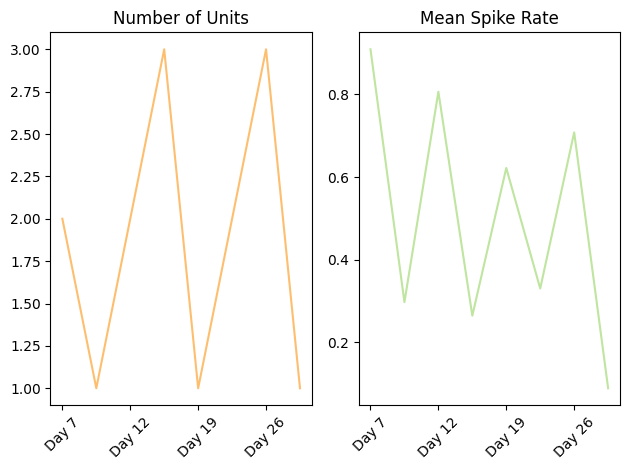

In [9]:
# Plot spike times over days

'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
'''

recordings = [
              '/spikingdata_curated/SO1_230613spikes_cleaned.npy', 
              '/spikingdata_curated/SO1_230615spikes_cleaned.npy', 
              '/spikingdata_curated/SO1_230620spikes_cleaned.npy',
              '/spikingdata_updated/SO1_230622spikes.npy', 
              '/spikingdata_curated/SO1_230629spikes_cleaned.npy', 
              '/spikingdata_updated/SO1_230705spikes.npy',
              '/spikingdata_curated/SO1_230706spikes_cleaned.npy', 
              '/spikingdata_updated/SO1_230721spikes.npy'
              ]
days = ['Day 5', 'Day 7', 'Day 12', 'Day 19', 'Day 26', 'Day 32', 'Day 33', 'Day 48']

date_values = ['0613','0615','0620','0622','0629','0705','0706','0721']

fpath_spikes = '/PATH_TO_DATA/figure3/'
fs = 30000
n_units = []
mean_spike_rate = []
spike_rate = []
for date, rec_path in zip(date_values, recordings):
    SO1_times = np.load(fpath_spikes+rec_path, allow_pickle=True)
    spike_times = []
    if date == '0613':
        spike_times.append(np.sort(np.concatenate((SO1_times[0],SO1_times[1])))/fs)
        spike_times.append(np.sort(np.concatenate((SO1_times[2],SO1_times[3])))/fs)
        num_pre_samples=18000000
    if date == '0615':
        spike_times.append(SO1_times[1]/fs)
        num_pre_samples=19800000
    if date == '0620':
        spike_times.append(SO1_times[0]/fs)
        spike_times.append(SO1_times[1]/fs)
        num_pre_samples=18000001
    if date == '0622':
        spike_times.append(SO1_times[0]/fs)
        spike_times.append(np.sort(np.concatenate((SO1_times[1],SO1_times[3])))/fs)
        spike_times.append(SO1_times[2]/fs)
        num_pre_samples=18000001
    if date == '0627':
        spike_times.append(SO1_times[0]/fs)
        num_pre_samples=36151040
    if date == '0629':
        spike_times.append(np.sort(np.concatenate((SO1_times[1],SO1_times[2])))/fs)
    if date == '0705':
        spike_times.append(SO1_times[0]/fs)
        spike_times.append(SO1_times[1]/fs)
        num_pre_samples=36605696
    if date == '0706':
        spike_times.append(SO1_times[0]/fs)
        spike_times.append(SO1_times[1]/fs)
        spike_times.append(np.sort(np.concatenate((SO1_times[2],SO1_times[3])))/fs)
        num_pre_samples=12660001
    if date == '0721':
        spike_times.append(SO1_times[0]/fs)
        num_pre_samples=18134784
    n_units.append(len(spike_times))
    rate_temp = []
    for spikes in spike_times:
        rate_temp.append(len(spikes)/(max(spikes)-min(spikes)))
    mean_spike_rate.append(np.mean(rate_temp))
    spike_rate.append(rate_temp)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=False)

ax[0].plot(range(len(days)),n_units, color=rgba1)
ax[0].set_xticklabels(days, rotation=45)
ax[1].plot(range(len(days)),mean_spike_rate, color=rgba2)
ax[1].set_xticklabels(days, rotation=45)
ax[0].set_title('Number of Units')
ax[1].set_title('Mean Spike Rate')

plt.tight_layout()

## Recreating Fig 3D

In [10]:
import xarray as xr

In [11]:
#build xarray for easier computation
import re
dayInt = []
for day in days:
    dayInt.append(int(re.findall(r'\d+', day)[0]))
dayInt

day_das = []
for spikes, day in zip(spike_rate, dayInt):
    units = []
    i = 0
    for unit in spikes:
        units.append(f'unit{i}')
        i+=1

    da = xr.DataArray(spikes, coords=[units], dims=['unit'])
    da['day'] = day

    day_das.append(da)
spikes_da = xr.concat(day_das, dim='day')
spikes_da

<xarray.DataArray (day: 8, unit: 3)> Size: 192B
array([[0.90504155, 0.91408089,        nan],
       [0.29676218,        nan,        nan],
       [1.47407611, 0.13896509,        nan],
       [0.26684455, 0.3718224 , 0.15309639],
       [0.621894  ,        nan,        nan],
       [0.46634589, 0.19320829,        nan],
       [1.8181304 , 0.05804339, 0.24815896],
       [0.08801829,        nan,        nan]])
Coordinates:
  * unit     (unit) <U5 60B 'unit0' 'unit1' 'unit2'
  * day      (day) int64 64B 5 7 12 19 26 32 33 48

In [24]:
# the median time between data collects is 7 days, bin the data as such
bins = []
ind_bin = []
start = None

wlen = 7

for day, day_da in spikes_da.groupby('day'):
    if(start == None): # first element of first bin
        start = 1
        ind_bin.append(day_da)
    elif(day > start + wlen): # must start new bin
        if(day < start + (wlen*2)): # no empty bin between this bin and prev bin
            #add prev bin to bins, start new bin
            dummy_da = xr.concat(ind_bin, dim='day')
            n = start + int(wlen/2) + 1
            bin_str = f'{n:02}'+r'$\pm$'+f'{int(wlen/2)}'
            dummy_da['bin'] = bin_str 
            bins.append(dummy_da)
            start += wlen
            ind_bin = [day_da]
        else: # this day belongs in different bin, add intermediate bins, then start new bin
            # add prev bin to bins
            dummy_da = xr.concat(ind_bin, dim='day')
            n = start + int(wlen/2) + 1
            bin_str = f'{n:02}'+r'$\pm$'+f'{int(wlen/2)}'
            dummy_da['bin'] = bin_str
            bins.append(dummy_da)
            start += wlen

            num_interms = int((day-start)/wlen)
            print(start)
            for i in np.arange(num_interms):
                ind_bin = [day_da.copy(data = np.zeros((len(day_da['unit']),)))]
                d_da = xr.concat(ind_bin, dim='day')
                n = start + int(wlen/2) + 1
                bin_str = f'{n:02}'+r'$\pm$'+f'{int(wlen/2)}'
                d_da['bin'] = bin_str 
                bins.append(d_da)
                start += wlen
            
            ind_bin = [day_da]
    else: # append to existing bin
        ind_bin.append(day_da)

    if(dayInt[-1]==day): # if last element, append this bin to bins
        dummy_da = xr.concat(ind_bin, dim='day')
        n = start + int(wlen/2) + 1
        bin_str = f'{n:02}'+r'$\pm$'+f'{int(wlen/2)}'
        dummy_da['bin'] = bin_str
        bins.append(dummy_da)

bins_da = xr.concat(bins, dim='day')
bins_da

36
47$\pm$3


/tmp/ipykernel_2654508/3083254019.py:8: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for day, day_da in spikes_da.groupby('day'):


<xarray.DataArray (day: 9, unit: 3)> Size: 216B
array([[0.90504155, 0.91408089,        nan],
       [0.29676218,        nan,        nan],
       [1.47407611, 0.13896509,        nan],
       [0.26684455, 0.3718224 , 0.15309639],
       [0.621894  ,        nan,        nan],
       [0.46634589, 0.19320829,        nan],
       [1.8181304 , 0.05804339, 0.24815896],
       [0.        , 0.        , 0.        ],
       [0.08801829,        nan,        nan]])
Coordinates:
  * unit     (unit) <U5 60B 'unit0' 'unit1' 'unit2'
  * day      (day) int64 72B 5 7 12 19 26 32 33 48 48
    bin      (day) <U8 288B '05$\\pm$3' '05$\\pm$3' ... '40$\\pm$3' '47$\\pm$3'

In [25]:
bin_means = []
bin_stds = []
for bin_day, bin_da in bins_da.groupby('bin'):
    mean_da = bin_da.mean(dim='unit').mean(dim='day')
    mean_da['bin'] = bin_day

    std_da = None
    if(len(bin_da['day']) > 1):
        std_da = bin_da.std(dim='unit').std(dim='day')
    else:
        std_da = bin_da.std(dim='unit')
        del std_da['day']
    std_da['bin'] = bin_day

    bin_means.append(mean_da)
    bin_stds.append(std_da)

bin_means_da = xr.concat(bin_means, dim='bin')
bin_stds_da = xr.concat(bin_stds, dim='bin')
bin_stds_da

<xarray.DataArray (bin: 7, day: 1)> Size: 56B
array([[0.00225984],
       [0.66755551],
       [0.08931845],
       [0.        ],
       [0.32608079],
       [0.        ],
       [0.        ]])
Coordinates:
  * bin      (bin) <U8 224B '05$\\pm$3' '12$\\pm$3' ... '40$\\pm$3' '47$\\pm$3'
Dimensions without coordinates: day

how many organoids, how many channels, etc
fix sorting of days

In [27]:
bins_da

<xarray.DataArray (day: 9, unit: 3)> Size: 216B
array([[0.90504155, 0.91408089,        nan],
       [0.29676218,        nan,        nan],
       [1.47407611, 0.13896509,        nan],
       [0.26684455, 0.3718224 , 0.15309639],
       [0.621894  ,        nan,        nan],
       [0.46634589, 0.19320829,        nan],
       [1.8181304 , 0.05804339, 0.24815896],
       [0.        , 0.        , 0.        ],
       [0.08801829,        nan,        nan]])
Coordinates:
  * unit     (unit) <U5 60B 'unit0' 'unit1' 'unit2'
  * day      (day) int64 72B 5 7 12 19 26 32 33 48 48
    bin      (day) <U8 288B '05$\\pm$3' '05$\\pm$3' ... '40$\\pm$3' '47$\\pm$3'

In [28]:
bin_means_da

<xarray.DataArray (bin: 7)> Size: 56B
array([0.6031617 , 0.8065206 , 0.26392111, 0.621894  , 0.518944  ,
       0.        , 0.08801829])
Coordinates:
  * bin      (bin) <U8 224B '05$\\pm$3' '12$\\pm$3' ... '40$\\pm$3' '47$\\pm$3'

In [29]:
bin_stds_da

<xarray.DataArray (bin: 7, day: 1)> Size: 56B
array([[0.00225984],
       [0.66755551],
       [0.08931845],
       [0.        ],
       [0.32608079],
       [0.        ],
       [0.        ]])
Coordinates:
  * bin      (bin) <U8 224B '05$\\pm$3' '12$\\pm$3' ... '40$\\pm$3' '47$\\pm$3'
Dimensions without coordinates: day

/tmp/ipykernel_2654508/4208748649.py:13: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for day, day_da in bin_da.groupby('day'):


Text(0.5, 0, 'Day of Experiment')

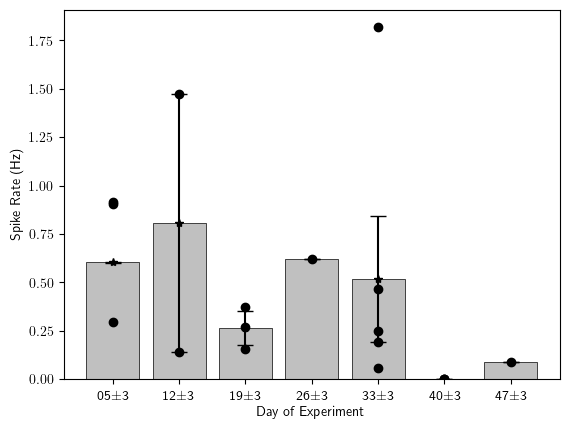

In [26]:
plt.rcParams['text.usetex'] = True
day_ranges = []
for i in np.arange(5, 5+(wlen*len(bins)), wlen):
    day_ranges.append(f'{i+int(wlen/2)}'+r'$\pm$' +f'{int(wlen/2)}')
day_ranges

plt.bar(bin_means_da['bin'].values, bin_means_da.values,
        linewidth=0.5, edgecolor='black', color='silver')



for bin_label, bin_da in bins_da.groupby('bin'):
    for day, day_da in bin_da.groupby('day'):
        plt.scatter(np.repeat(bin_label, len(day_da['unit'])),
                    day_da.values, color='black'
                    )
    plt.errorbar(bin_label, bin_means_da.sel(bin=bin_label),
             bin_stds_da.sel(bin=bin_label).values,
             fmt='*', capsize=6, color='black')
plt.ylabel('Spike Rate (Hz)')
plt.xlabel('Day of Experiment')

## Spike Rate Linear/Polynomial Plot

In [12]:
spikes_da

<xarray.DataArray (day: 8, unit: 3)> Size: 192B
array([[0.90504155, 0.91408089,        nan],
       [0.29676218,        nan,        nan],
       [1.47407611, 0.13896509,        nan],
       [0.26684455, 0.3718224 , 0.15309639],
       [0.621894  ,        nan,        nan],
       [0.46634589, 0.19320829,        nan],
       [1.8181304 , 0.05804339, 0.24815896],
       [0.08801829,        nan,        nan]])
Coordinates:
  * unit     (unit) <U5 60B 'unit0' 'unit1' 'unit2'
  * day      (day) int64 64B 5 7 12 19 26 32 33 48

In [15]:
spikes_da.values

array([[0.90504155, 0.91408089,        nan],
       [0.29676218,        nan,        nan],
       [1.47407611, 0.13896509,        nan],
       [0.26684455, 0.3718224 , 0.15309639],
       [0.621894  ,        nan,        nan],
       [0.46634589, 0.19320829,        nan],
       [1.8181304 , 0.05804339, 0.24815896],
       [0.08801829,        nan,        nan]])

In [19]:
spikes_da.mean(dim='unit')

<xarray.DataArray (day: 8)> Size: 64B
array([0.90956122, 0.29676218, 0.8065206 , 0.26392111, 0.621894  ,
       0.32977709, 0.70811092, 0.08801829])
Coordinates:
  * day      (day) int64 64B 5 7 12 19 26 32 33 48

In [ ]:
plt.errorbar(bin_label, bin_means_da.sel(bin=bin_label),
             bin_stds_da.sel(bin=bin_label).values,
             fmt='*', capsize=6, color='black')

/tmp/ipykernel_4040067/2787711359.py:2: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for day, day_da in spikes_da.groupby('day'):


Text(0, 0.5, 'Spike Rate (Hz)')

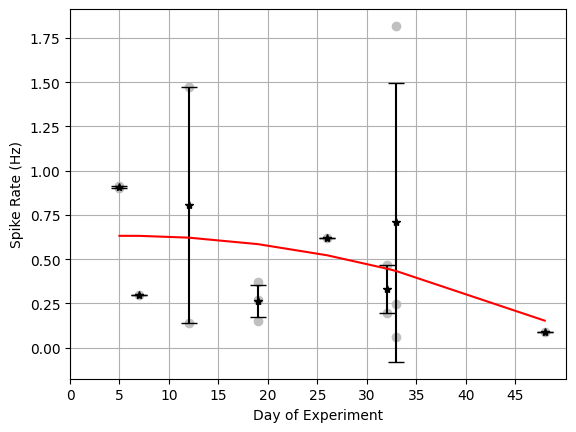

In [121]:
plt.grid()
for day, day_da in spikes_da.groupby('day'):
    plt.scatter([day]*3, day_da.values, c='silver')
plt.errorbar(spikes_da.coords['day'], spikes_da.mean(dim='unit'), spikes_da.std(dim='unit'),
             fmt='*', capsize=6, color='black')
#plt.plot(spikes_da.coords['day'], spikes_da.mean(dim='unit'))
coefs = np.polyfit(spikes_da.coords['day'], spikes_da.mean(dim='unit'), 2)
p = np.poly1d(coefs)
plt.plot(spikes_da.coords['day'], p(spikes_da.coords['day']), 'r-')
plt.xticks(np.arange(0, 50, 5))
plt.xlabel('Day of Experiment')
plt.ylabel('Spike Rate (Hz)')

# Example templates

In [82]:

alldata = []
spike_template_files = [
                        'spikingdata_updated/SO1_230705waveforms_folder/templates_average.npy',
                        ]
fpath_spikes = '/PATH_TO_DATA/figure3/'

Days = ['0705']
short_spike_inds = [1,1,1,0]
alldata = []
dy = 0
template_data = np.load(fpath_spikes+spike_template_files[short_index[0]])
print(template_data.shape)

fig, axes = plt.subplots(2, 1, layout='tight')
cmap = matplotlib.cm.get_cmap('Spectral')


for i in np.arange(2):
    axes[i].plot(template_data[i,:,2], color=cmap((i+1)/3))
    axes[i].set_title(f'Unit {i} Template')

fig.suptitle('SO1 7/5/25 Templates')
'''
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
rgba1 = cmap(1/3)
rgba2 = cmap(2/3)
rgba3 = cmap(3/4)

print(dy)
#plt.plot(alldata[0][:,2])
fig, ax = plt.subplots(1, len(short_recordings)-1, sharex=True, sharey=True)
for i in np.arange(len(ax)):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

    ax[i].plot(alldata[i][:,2] + 0.5*dy, color=rgba1)
    ax[i].plot(alldata[i][:,1] + 1.5*dy, color=rgba2)
    ax[i].plot(alldata[i][:,0] + 2.5*dy, color=rgba3)

    ax[i].get_xaxis().set_visible(False)
    ax[i].set_title(days[short_index[i]])

plt.ylim(0, (3*dy))
plt.tight_layout()
plt.yticks([0.5*dy, dy*1.5, 2.5*dy], labels=['West', 'East', 'North'])
'''

FileNotFoundError: [Errno 2] No such file or directory: '/media/t7/surpass/electrophysiology/Gracias Data/ExperimentalData_2month_Round1/spikingdata_updated/SO1_230705waveforms_folder/templates_average.npy'

(2, 90, 3)


/tmp/ipykernel_2399765/2058857581.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


Text(0.5, 0.98, 'SO1 7/5/25 Templates')

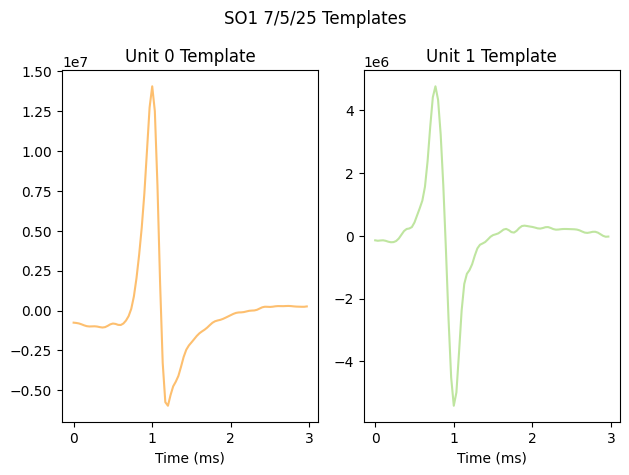

In [36]:

alldata = []
spike_template_files = [
                        'spikingdata_updated/SO1_230622waveforms_folder/templates_average.npy',
                        ]
fpath_spikes = '/PATH_TO_DATA/figure3/'

Days = ['0705']
short_spike_inds = [1,1,1,0]
alldata = []
dy = 0
template_data = np.load(fpath_spikes+spike_template_files[short_index[0]])
print(template_data.shape)

fig, axes = plt.subplots(1, 2, layout='tight')
cmap = matplotlib.cm.get_cmap('Spectral')


for i in np.arange(2):
    axes[i].plot(np.arange(0, 0.003, 1/30000)*1000, template_data[i,:,2], color=cmap((i+1)/3))
    axes[i].set_title(f'Unit {i} Template')
    axes[i].set_xlabel('Time (ms)')

fig.suptitle('SO1 7/5/25 Templates')

In [32]:
np.arange(0, 0.003, 1/30000)*1000

array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
       0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
       0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
       0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
       0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
       1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
       1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ,
       1.33333333, 1.36666667, 1.4       , 1.43333333, 1.46666667,
       1.5       , 1.53333333, 1.56666667, 1.6       , 1.63333333,
       1.66666667, 1.7       , 1.73333333, 1.76666667, 1.8       ,
       1.83333333, 1.86666667, 1.9       , 1.93333333, 1.96666667,
       2.        , 2.03333333, 2.06666667, 2.1       , 2.13333333,
       2.16666667, 2.2       , 2.23333333, 2.26666667, 2.3       ,
       2.33333333, 2.36666667, 2.4       , 2.43333333, 2.46666

In [ ]:
90 samples * 1s/30000 samples

In [3]:
def pull_spike_data(fpath, recording, nwbfile, unit, bandpass = True, freqmin = 300, freqmax = 6000, artifact = 10):
    '''
    This function pulls and returns the max amplitude 
    and spike times for a given recording
    
    Parameters
    fpath (string)   : the  path to the folder containing your 
                       waveforms folder and .npy file (if current  
                       folder, input '.')
    unit (int)       : the unit you would like to analyze
    nwbfile (string) : the path to the nwb file with
                     raw recording 

    Return
    spike_amps (array):  1D array of spike amplitudes for given unit
    spike_times (array): 1D array of spike times for given unit
    '''
    # get raw recording data
    nwb_rec = se.read_nwb(fpath+'NWBFiles/'+nwbfile)
    #rec_data = pd.DataFrame(nwb_rec.get_traces())
    if(bandpass):
        nwb_rec_filtered = spre.bandpass_filter(nwb_rec, freq_min=freqmin, freq_max=freqmax)
        nwb_rec_preprocessed = spre.whiten(nwb_rec_filtered, dtype='float32')
        channel = nwb_rec_preprocessed.get_traces()[:,0]
        stimulation_trigger_frames = np.where(np.abs(channel)>artifact)
        nwb_rec = spre.remove_artifacts(nwb_rec_preprocessed,
                                        list_triggers=stimulation_trigger_frames[0].tolist(),
                                        ms_before=10, ms_after=10)

    # get spike data
    #spike_amps = np.load(fpath+f'spikingdata/{recording}waveforms_folder/spike_amplitudes/amplitude_segment_0.npy') 
    #print(spike_amps)
    spike_times = np.load(fpath+f'{recording}', allow_pickle=True) 
    
    #if(spike_amps.size == spike_times[0].size):
    print(spike_times.shape)
    return spike_times[unit], nwb_rec

In [4]:
fpath = '/PATH_TO_DATA/figure3/'

/tmp/ipykernel_3208457/218102096.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


(4,)
(4,)
(4,)


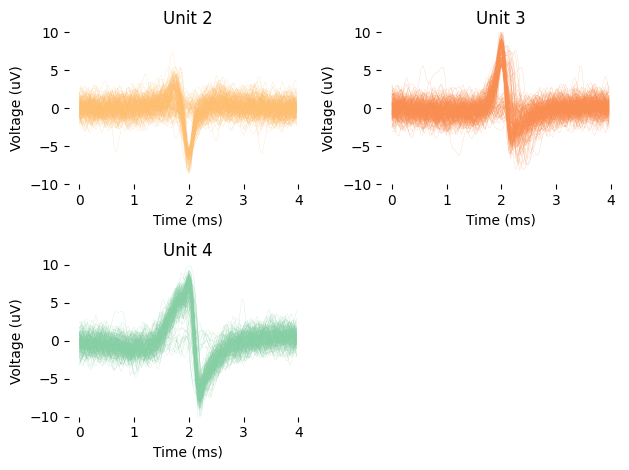

In [9]:
# merge units 2 + 4
# real units: 1, 2/4, 3

# say 20 ms window

fig, axes = plt.subplots(2,2, layout='tight')

units = [[1], [2], [3]]
channels = [2, 2, 2]

cmap = matplotlib.cm.get_cmap('Spectral')
cmaps = [cmap(1/3), cmap(1.5/6), cmap(3/4)]

times = np.arange(0, 4, 1/30)

for unit, spikechan, ax, color in zip(units, channels, axes.flatten(), cmaps):
    #if len(unit)==1:
    spiketimes, nwb = pull_spike_data(fpath, 'spikingdata/SO1_230622spikes.npy', 'SO1_230622_Full.nwb', unit[0])
    traces = nwb.get_traces()

    for spiketime in spiketimes:
        ax.plot(times, traces[spiketime-60:spiketime+60, spikechan], color = color,linewidth=0.1)

    ax.set_title(f'Unit {unit[0]+1}')
        
            
            
    '''        
    else:
        spiketimes_1, nwb_1 = pull_spike_data(fpath, 'spikingdata/SO1_230622spikes.npy', 'SO1_230622_Full.nwb', unit[0])
        spiketimes_2, nwb_2 = pull_spike_data(fpath, 'spikingdata/SO1_230622spikes.npy', 'SO1_230622_Full.nwb', unit[1])

        traces_1 = nwb_1.get_traces()
        for spiketime in spiketimes_1:
            ax.plot(times, traces_1[spiketime-60:spiketime+60, spikechan], color = color, linewidth=0.2)
        
        traces_2 = nwb_2.get_traces()
        for spiketime in spiketimes_2:
            ax.plot(times, traces_2[spiketime-60:spiketime+60, spikechan], color = color, linewidth=0.1)

        ax.set_title(f'Unit 2')
    '''
        
    
    ax.set_ylabel('Voltage (uV)')
    ax.set_xlabel('Time (ms)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_ylim(-10, 10)
axes.flatten()[3].set_visible(False)